**ИССЛЕДОВАНИЕ ИСТОРИЧЕСКИХ ДАННЫХ О ПРОДАЖАХ ВИДЕОИГР**

**Общее описание проекта**

Проект включает в себя исследование собранной из открытых источников базы данных о продажах видеоигр за период с 1980 по 2016 год. Целью исследования является определение закономерностей, влияющих на коммерческую успешность игры, и предоставление специалистам по маркетингу выводов и рекомендаций на основе этих закономерностей.

Этапы проработки проекта:

1. Обзор данных:
- изучена общая информация о базе данных
2. Предобработка данных:
- устранены дубликаты
- устранены пропуски
- параметры преведены к типам данных, удобных для исследования, введены новые параметры
3. Исследовательский анализ данных:
- исследованы частотные характеристики параметров объявлений
- выявлены взаимосвязи этих характеристик с рыночной ценой объекта
4. Определение портрета пользователя:
- определена популярность игровых платформ, в зависимости от региона продаж
- определена популярность игровых жанров, в зависимости от региона продаж
- определена взаимосвязь продаж и возрастного рейтинга игр, в зависимости от региона продаж
5. Проверка гипотез:
- проверены предположения о равенстве и различии продаж в отдельных категориях

### Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings

In [2]:
# загрузка датасета
data = pd.read_csv('/datasets/games.csv')

In [3]:
# обзор датасета
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
#display(data.describe())
display(data.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


- названия столбцов в смешанном регистре
- есть пропуски в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating
- год выпуска имеет неверный тип данных
- оценка пользователей имеет неверный тип данных

In [5]:
# корректировка названий столбцов
for col in data.columns:
    data = data.rename(columns={col: col.lower()})
    
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Предобработка данных

**обработка пропусков**

возможные причины пропусков:
- все: техническая ошибка
- оценки: отсутствие баз данных по оценкам для игр, выпущенных до определённого года; отсутствие интереса к игре
- рейтинг: отсутвие требований по возрастной маркировке игр до определённого года

In [6]:
# пропусков всего
data.isna().apply(lambda val: (sum(val)/len(data))*100)

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

In [7]:
# обработка пропусков в столбце year_of_release

# проверим, есть ли у какого-либо года дробная часть
print(data.loc[data['year_of_release'] % 1 > 0, 'year_of_release'].count())

# пропусков по году не более 2% и их сложно заполнить, удалим эти записи
data = data.dropna(subset=['year_of_release'])

0


In [8]:
# обработка пропусков в столбце name

# название не важно для исследования, заменим на условное
data['name'] = data['name'].fillna('default_name')

In [9]:
# обработка пропусков в столце genre

# пропусков по жанру менее 1% и их сложно заполнить, удалим эти записи для экономии времени
data = data.dropna(subset=['genre'])

- обработка пропусков в столбце critic_score

In [10]:
# сопоставление доли пропусков и года выпуска 

display(data[['year_of_release', 'critic_score', 'name']].groupby(by='year_of_release').count())

print('Доля пропусков до 2000 года:', 
      data.loc[data['year_of_release'] < 2000, 'critic_score'].isna().sum() / data['critic_score'].shape[0])

,critic_score,name
year_of_release,,
1980.0,0,9
1981.0,0,46
1982.0,0,36
1983.0,0,17
1984.0,0,14
1985.0,1,14
1986.0,0,21
1987.0,0,16
1988.0,1,15


Доля пропусков до 2000 года: 0.11420578934565799


Оценки критиков были всегда, но до 1999 их количество было незначительным, хотя и самих игр было немного.

In [11]:
#pd.options.mode.chained_assignment = None # отключаем предупреждения
warnings.simplefilter('ignore', category=RuntimeWarning) # временно отключаем предупереждения

column_to_fill = 'critic_score'
# через apply
def score_fill(row):
    
    # если значение не NaN, возвращаем его обратно
    if not np.isnan(row[column_to_fill]):
        return row[column_to_fill]
    
    # минимальный размер условной выборки заполненных оценок
    min_count = 30
    
    year = row['year_of_release']
    platform = row['platform']
    genre = row['genre']
    
    # все оценки сочетания платформа-жанр за год
    scores_1 = data.loc[(data['year_of_release'] == year) &
                        (data['platform'] == platform) &
                        (data['genre'] == genre) &
                        (data[column_to_fill].notna().sum() >= min_count),
                        column_to_fill]
            
    # все оценки данной платформы за год
    scores_2 = data.loc[(data['year_of_release'] == year) &
                        (data['platform'] == platform) &
                        (data[column_to_fill].notna().sum() >= min_count),
                        column_to_fill]
            
    # все оценки данного жанра за год
    scores_3 = data.loc[(data['year_of_release'] == year) &
                        (data['genre'] == genre) &
                        (data[column_to_fill].notna().sum() >= min_count),
                        column_to_fill]
        
    if not scores_1.empty:
        # если за год есть оценки для сочетания платформа-жанр, заполняем медианой именно для такого сочетания
        return scores_1.median()
    
    elif not scores_2.empty and not scores_3.empty:         
        # иначе если за год есть оценки для данной платформы и есть оценки для данного жанра,
        # заполняем усреднённым значением медианных оценок платформы и жанра
        return (scores_2.median() + scores_3.median()) / 2
                
    elif not scores_2.empty:
        # иначе если за год есть оценки только для платформы, заполняем медианой для платформы
        return scores_2.median()
                
    elif not scores_3.empty:
        # иначе если за год есть оценки только для жанра, заполняем медианой для платформы
        return scores_2.median()
    
    else:
        # иначе если за год нет никаких оценок ни для данной платформы ни для жанра, оставляем NaN
        return np.nan

data['critic_score_new'] = data.apply(score_fill, axis=1)
warnings.simplefilter('default', category=RuntimeWarning) # включаем предупреждения обратно

- обработка пропусков в столце user_score

In [12]:
# сопоставление доли пропусков и года выпуска 

display(data[['year_of_release', 'user_score', 'name']].groupby(by='year_of_release').count())

print('Доля пропусков до 2000 года:', 
      data.loc[data['year_of_release'] < 2000, 'user_score'].isna().sum() / data['user_score'].shape[0])

,user_score,name
year_of_release,,
1980.0,0,9
1981.0,0,46
1982.0,0,36
1983.0,0,17
1984.0,0,14
1985.0,1,14
1986.0,0,21
1987.0,0,16
1988.0,1,15


Доля пропусков до 2000 года: 0.11390172707370469


Распределение пользовательских отзывов по годам аналогично отзывам критиков

In [13]:
# приведём тип данных оценок пользователей к float
try:
    data['user_score'] = data['user_score'].astype('float')
except:
    print(data['user_score'].unique())   

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


Оценки пользователей содержат аббревиатуру 'tbd', что в данном случае можно расшифровать как 'to be determined', это значит, что оценка ещё не определёна. Возможно она не определёна т.к. игры ещё не выходили в продажу.

In [14]:
# оценка не определена, т.к. игра ещё не вышла в продажу?
data.loc[(data['user_score'] == 'tbd') & ((data['na_sales'] > 0) | (data['eu_sales'] > 0) | (data['jp_sales'] > 0))].count()

name                2375
platform            2375
year_of_release     2375
genre               2375
na_sales            2375
eu_sales            2375
jp_sales            2375
other_sales         2375
critic_score        1056
user_score          2375
rating              2325
critic_score_new    2252
dtype: int64

Оказывается, продажи для игр с такой оценкой уже имели место, возможно на момент формирования базы данных ещё не были получены оценки из всех источников. Это подтверждается тем, что для половины таких игр уже есть оценки критиков. Удалять эти данные не стоит, следует обработать налогично nan.

In [15]:
# заменим tbd на nan
data.loc[:, 'user_score'].replace(to_replace='tbd', value=np.nan, inplace=True)

In [16]:
# перед дальнейшей обработкой пропусков в этом столбце необходимо откорректирвоать тип данных
data['user_score'] = data['user_score'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16444 non-null  object 
 1   platform          16444 non-null  object 
 2   year_of_release   16444 non-null  float64
 3   genre             16444 non-null  object 
 4   na_sales          16444 non-null  float64
 5   eu_sales          16444 non-null  float64
 6   jp_sales          16444 non-null  float64
 7   other_sales       16444 non-null  float64
 8   critic_score      7983 non-null   float64
 9   user_score        7463 non-null   float64
 10  rating            9768 non-null   object 
 11  critic_score_new  14231 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.6+ MB


In [17]:
# обработаем пропуски в оценках пользователей аналогично пропускам в оценках критиков
column_to_fill = 'user_score'

warnings.simplefilter('ignore', category=RuntimeWarning) # временно отключаем предупереждения
data['user_score_new'] = data.apply(score_fill, axis=1)

warnings.simplefilter('default', category=RuntimeWarning) # включаем предупреждения обратно

- обработка пропусков в столце rating

In [18]:
print(data['rating'].unique())
print('Пропусков рейтинга:', data['rating'].isna().sum())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']
Пропусков рейтинга: 6676


In [19]:
# рейтинг не определен, т.к. игра ещё не вышла в продажу?
data.loc[(data['rating'].isna()) & ((data['na_sales'] > 0) | (data['eu_sales'] > 0) | (data['jp_sales'] > 0))].count()

name                6674
platform            6674
year_of_release     6674
genre               6674
na_sales            6674
eu_sales            6674
jp_sales            6674
other_sales         6674
critic_score          81
user_score            83
rating                 0
critic_score_new    4699
user_score_new      4811
dtype: int64

In [20]:
data.loc[data['rating'].isna(), ['genre', 'name']].groupby(by='genre').count()

,name
genre,
Action,1161
Adventure,853
Fighting,405
Misc,859
Platform,317
Puzzle,233
Racing,370
Role-Playing,711
Shooter,300


Все игры без рейтинга были выпущены в продажу. Однако для таких игр практически не было оценок критиков и пользоватлей. Так же такие игры выпущены в различных жанрах, а не в каком-то специфическом.

In [21]:
# сперва обработаем имеющиеся неявные дубликаты (K-A то же, что E), для большей точности определения рейтинга старых игр
data.loc[:, 'rating'].replace(to_replace='K-A', value='E', inplace=True)

In [22]:
# в датасете имеются игры с рейтингом RP (рейтинг ожидается), проверим, были ли по ним продажи
data.loc[(data['rating'] == 'RP') & ((data['na_sales'] > 0) | (data['eu_sales'] > 0) | (data['jp_sales'] > 0))].count()

name                1
platform            1
year_of_release     1
genre               1
na_sales            1
eu_sales            1
jp_sales            1
other_sales         1
critic_score        1
user_score          1
rating              1
critic_score_new    1
user_score_new      1
dtype: int64

In [23]:
# игрa с рейтингом RP продавалaсь, обработаем этот рейтинг как nan
data.loc[:, 'rating'].replace(to_replace='RP', value=np.nan, inplace=True)

In [24]:
# возрастной рейтинг сложно определить на основе какого-либо из параметров, оставим пропуски, заменив nan на строковое значение
data.loc[data['rating'].isna(), 'rating'] = 'unknown'

Полностью обработаны пропуски в столбцах name, year_of_release, genre. Частично обработаны пропуски в столбцах critic_score, user_score.

Возможные причины пропусков - техническая ошибка, отсутствие значительного интереса к игре со стороны критиков и пользователей или отсутствие удобного способа массового сбора и систематизации оценок до широкого распространения интернета. 

Так же данные показывают, что самих игр до конца 90х выпускалось немного, и количество отзывов так же было небольшим.

Строки с оставшимися пропусками оставлены, т.к. будут использованы для исследования параметров без пропусков.

**обработка дубликатов**

In [25]:
# проверка на полные дубликаты
print('Полных дубликатов:', data.duplicated().sum())

Полных дубликатов: 0


In [26]:
# поиск неявных дубликатов в названиях платформ
sorted(data['platform'].unique())

['2600',
 '3DO',
 '3DS',
 'DC',
 'DS',
 'GB',
 'GBA',
 'GC',
 'GEN',
 'GG',
 'N64',
 'NES',
 'NG',
 'PC',
 'PCFX',
 'PS',
 'PS2',
 'PS3',
 'PS4',
 'PSP',
 'PSV',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS',
 'Wii',
 'WiiU',
 'X360',
 'XB',
 'XOne']

In [27]:
# поиск дубликатов в сочетании название-платформа-год выпуска
print('Дубликатов игр на платформе:', data[['name', 'platform', 'year_of_release']].duplicated().sum())

Дубликатов игр на платформе: 1


In [28]:
data.loc[data[['name', 'platform', 'year_of_release']].duplicated(keep=False), :]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_new,user_score_new
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,83.0,5.5
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E,83.0,5.5


In [29]:
# нужно сложить продажи в ЕС, исправим и удалим дубликат
data.loc[604, 'eu_sales'] += data.loc[16230, 'eu_sales']
data = data.drop([16230])

**исправление типов данных**

In [30]:
# приведём к целочисленному тип данных в столбцах года выпуска и числового рейтинга
data[['year_of_release']] = data[['year_of_release']].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16443 non-null  object 
 1   platform          16443 non-null  object 
 2   year_of_release   16443 non-null  int64  
 3   genre             16443 non-null  object 
 4   na_sales          16443 non-null  float64
 5   eu_sales          16443 non-null  float64
 6   jp_sales          16443 non-null  float64
 7   other_sales       16443 non-null  float64
 8   critic_score      7982 non-null   float64
 9   user_score        7462 non-null   float64
 10  rating            16443 non-null  object 
 11  critic_score_new  14230 non-null  float64
 12  user_score_new    14419 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 1.8+ MB


**исправление и удаление столбцов**

In [31]:
data['critic_score'] = data['critic_score_new']
data['user_score'] = data['user_score_new']

In [32]:
data = data.drop(columns=['critic_score_new', 'user_score_new'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     14230 non-null  float64
 9   user_score       14419 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [33]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'EC'], dtype=object)

**дополнение датасета расчётными данными**

In [34]:
# добавим столбец с суммарными продажами
data['all_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
#data.head(20)

### Исследовательский анализ данных

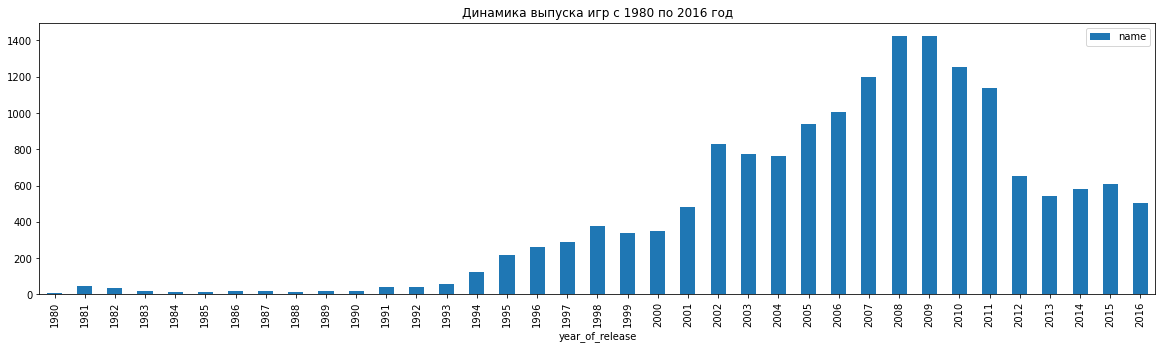

In [35]:
# динамика выпуска игр по годам
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar', figsize=(20, 5),
                                                                              title='Динамика выпуска игр с 1980 по 2016 год');

Начиная с 1994 года количество выпущенных игр за год стабильно росло, достигнув писка в 2008-2009 годах. Затем динамика стала замедляться, а в 2012 произошло резкое сокращение выпуска игр для указанных платформ. Затем с 2013 по 2016 год выпуск игр стагнировал.

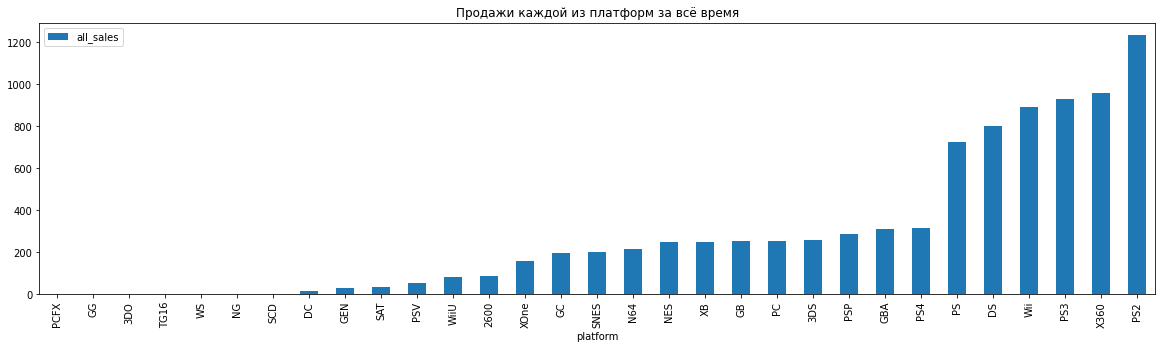

In [36]:
# исследуем как менялись продажи по платформам
data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales').plot(kind='bar', figsize=(20, 5),
                                                                       title='Продажи каждой из платформ за всё время');

Очевидные лидеры продаж - первые шесть платформ. Далее исследуем динамику их продаж по годам.

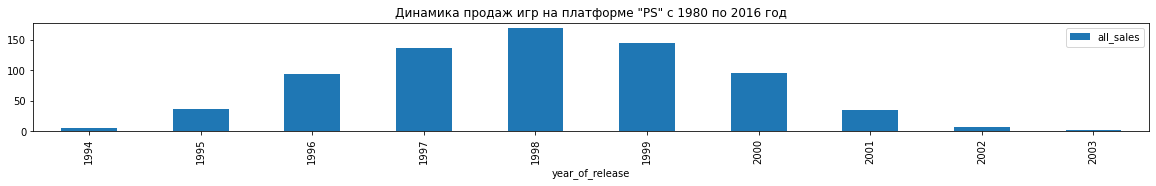

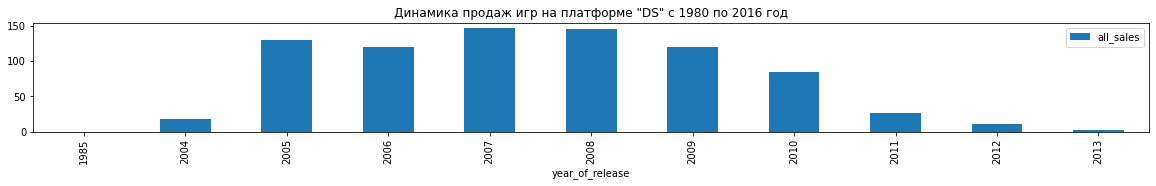

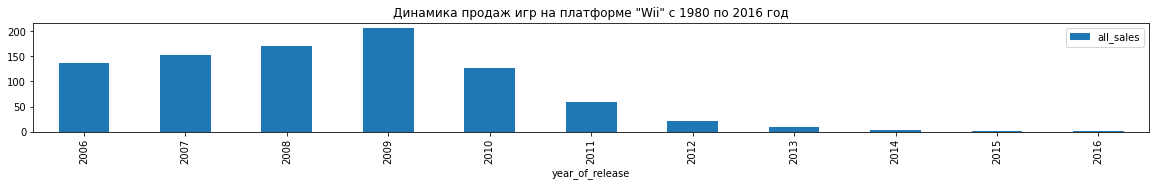

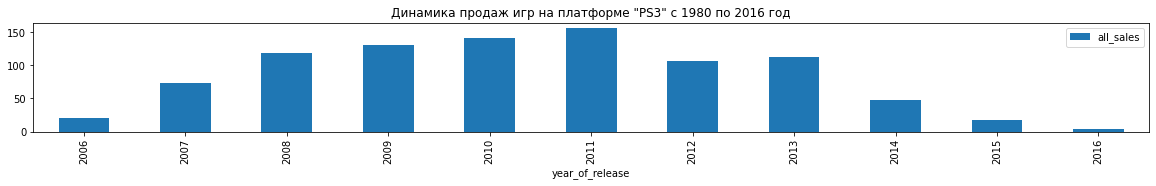

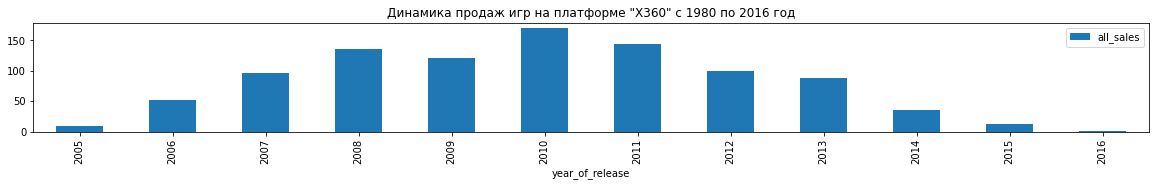

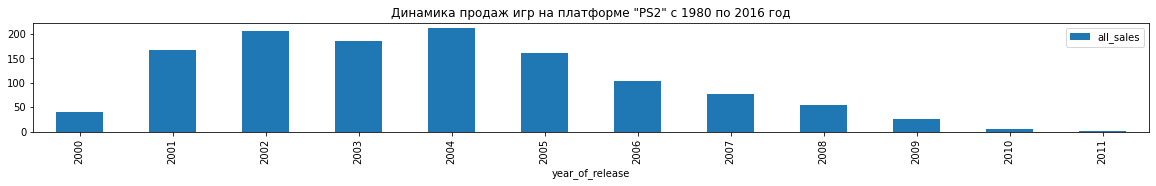

In [37]:
# 
top_platforms = list(data.pivot_table(index='platform',
                                      values='all_sales', aggfunc='sum').sort_values(by='all_sales').index.values[-6:])

for platform in top_platforms:
    t = f'Динамика продаж игр на платформе "{platform}" с 1980 по 2016 год'
    
    data.loc[data['platform'] == platform, :].pivot_table(index='year_of_release',
                                                          values='all_sales',
                                                          aggfunc='sum').plot(kind='bar', figsize=(20, 2), title=t);

Графики показывают, что средний срок "жизни" платформы составляет примерно 10 лет.
На графике для платформы "DS" указаны продажи в 1985, возможно в то время существовала одноимённая непопулярная платформа, либо это артефакт базы данных.

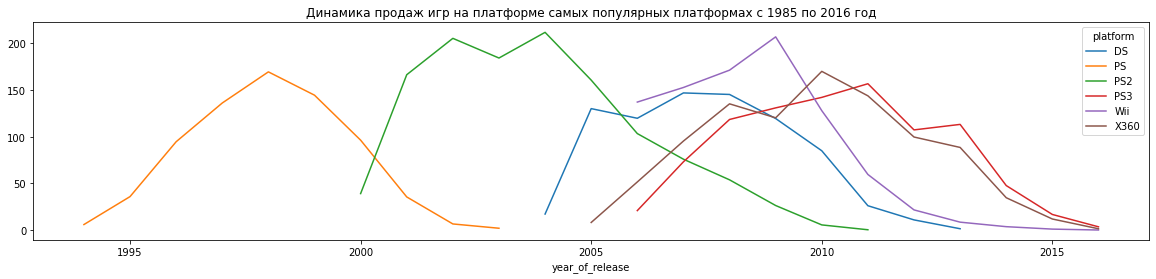

In [38]:
t = f'Динамика продаж игр на платформе самых популярных платформах с 1985 по 2016 год'

data.loc[(data['platform'].isin(top_platforms)) &
         (data['year_of_release'] > 1985), :].pivot_table(index='year_of_release',
                                                              values='all_sales',
                                                              columns='platform',
                                                              aggfunc='sum').plot(kind='line', figsize=(20, 4), title=t);

Лидер продаж сменяется примерно каждые 5 лет. Однако в период максимального роста рынка в 2006-2011 годов одновременно существовало несколько популярных, близко конкурирующих брендов.

Для дальнейших исследований имеет смысл брать период с 2013 по 2016 годы, после прохождения пика продаж и стабилизации рынка. Так же не стоит брать более ранние данные из-за того, что многих платформ и базовых технологий, серий игр, которые их определяли, уже может не быть на рынке.

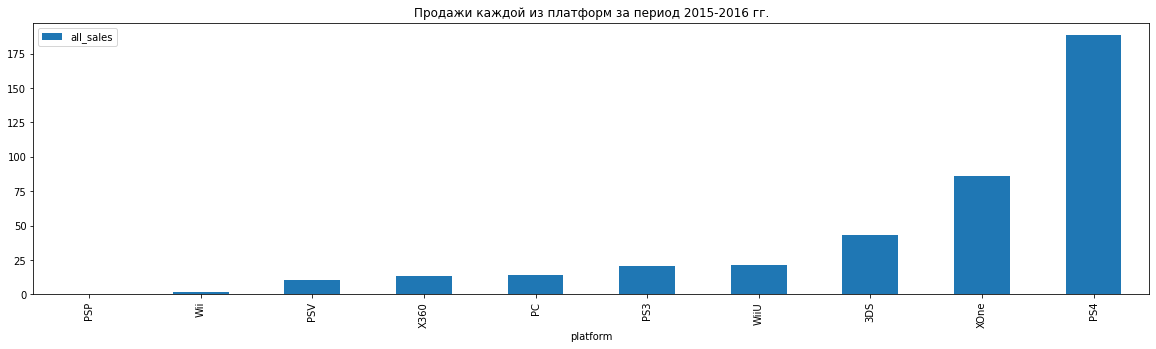

In [39]:
# взглянем ближе на лидеров продаж именно за этот период
data_last = data.loc[data['year_of_release'] >= 2015, :]

data_last.pivot_table(index='platform',
                      values='all_sales',
                      aggfunc='sum').sort_values(by='all_sales').plot(kind='bar', figsize=(20, 5),
                                                                    title='Продажи каждой из платформ за период 2015-2016 гг.');

Оказывается, действующих платформ не так много. Чтобы определить потенциал каждой из них, необходимо понять динамику их продаж. 

['PSP', 'Wii', 'PSV', 'X360', 'PC', 'PS3', 'WiiU', '3DS', 'XOne', 'PS4']


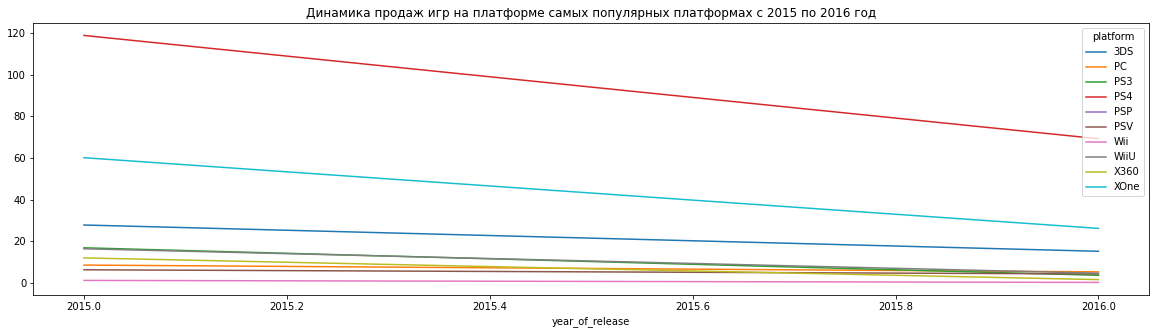

In [40]:
top_platforms_last = list(data_last.pivot_table(index='platform', values='all_sales', 
                                                aggfunc='sum').sort_values(by='all_sales').index.values)

t = f'Динамика продаж игр на платформе самых популярных платформах с 2015 по 2016 год'

data_last.loc[data['platform'].isin(top_platforms_last), :].pivot_table(index='year_of_release',
                                                                     values='all_sales',
                                                                     columns='platform',
                                                                     aggfunc='sum').plot(kind='line', figsize=(20, 5), title=t);

data_last.head()
print(top_platforms_last)

In [41]:
print('Старт продаж 3DS:', sorted(data.loc[data['platform'] == '3DS', 'year_of_release'].unique())[0])

Старт продаж 3DS: 2011


Платформы PS4, XOne, 3DS показывают максимальные результататы. Однако 3DS демонстрирует худшие показатели и на 2 года старше остальных.

Так же стоит обратить внимание на платформу PC, продажи для ПК хоть и небольшие, но на 2016 год чуть больше, чем у любой из оставшихся приставок и при этом относительно стабильные, эта платформа вряд ли уйдёт с рынка в ближайшие годы.

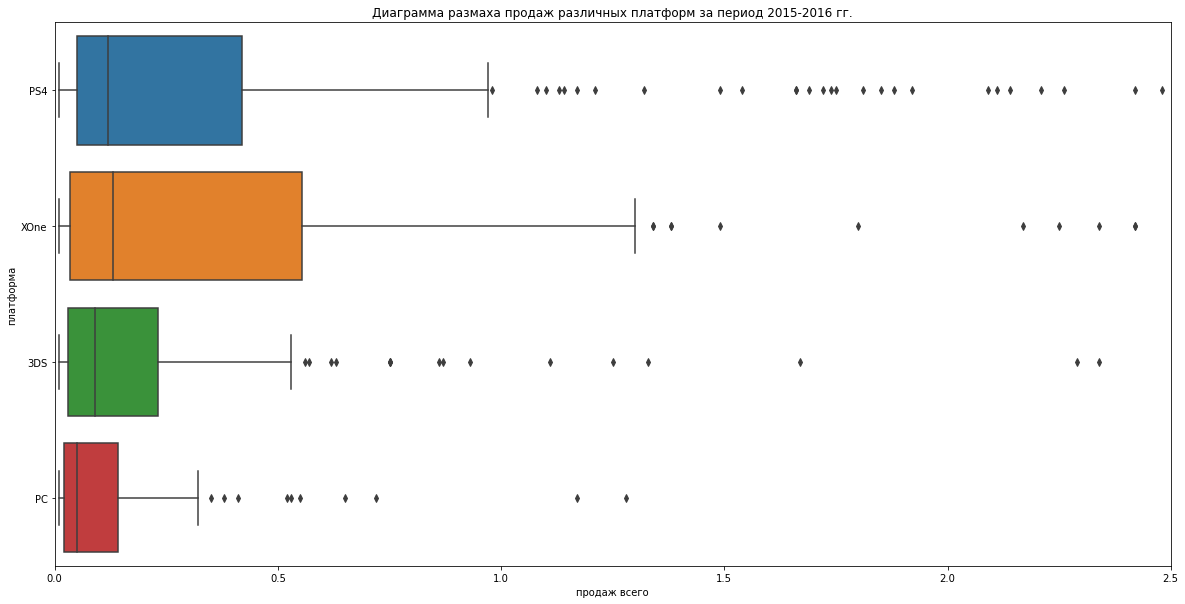

In [42]:
# диаграмма размаха по глобальным продажам игр в разбивке по перспективным платформам за выбранный период
data_top = data_last.loc[data_last['platform'].isin(['PS4', 'XOne', '3DS', 'PC']), :]

plt.figure(figsize=(20, 10), frameon=False)
plt.xlim(0, 2.5)

sns.boxplot(x='all_sales', y='platform', data=data_top[['platform', 'all_sales']], orient='h')

plt.xlabel('продаж всего')
plt.ylabel('платформа')
plt.title('Диаграмма размаха продаж различных платформ за период 2015-2016 гг.');

Положение первого квартиля у всех платформ примерно одинаковое, значит и заметно непопулярных игр в абсолютных величинах тоже примерно одинаковое количество. У игр на ПК этот показатель ещё меньше, но нужно учесть, что  и самих продаж этих игр меньше.

Несмотря на то, что для отдельные игры продаются очень хорошо, медианное количество продаж большинства игр меньше среднего, значит в целом "проходных" игр меньше чем "шедевров".

По максимальным продажам всё выглядит так же, как и на графике динамики продаж по годам: впереди PS4, затем XOne, 3DS и PC. Но несмотря на то, что крупных продаж у XOne меньше, чем у PS4, медиана и третий квартиль у неё больше, значит среднестатистическая игра на этой платформе более востребована.

Коэффициент корреляции количества продаж игры от оценок критиков: 0.27


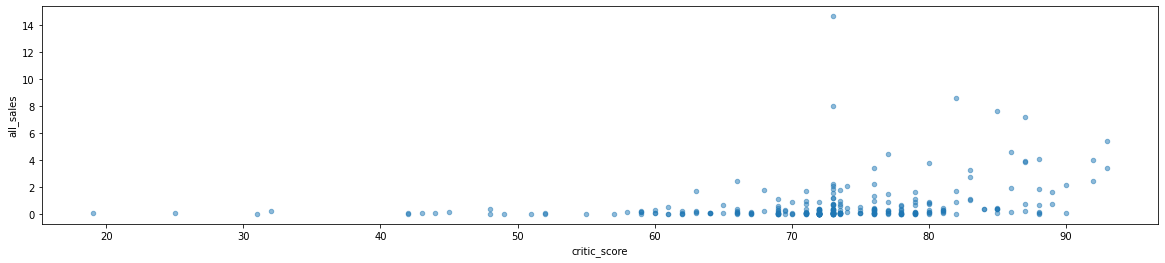

In [43]:
# корреляция продаж и отзывов
print('Коэффициент корреляции количества продаж игры от оценок критиков:',
      round(data_top.loc[data_top['platform'] == 'PS4', :]['critic_score'].corr(data_top.loc[data_top['platform'] == 'PS4', :]['all_sales']), 2))

data_top.loc[data_top['platform'] == 'PS4', :].plot(kind='scatter', x='critic_score', y='all_sales', alpha=0.5, figsize=(20, 4));

Коэффициент корреляции количества продаж игры от оценок пользователей: -0.1


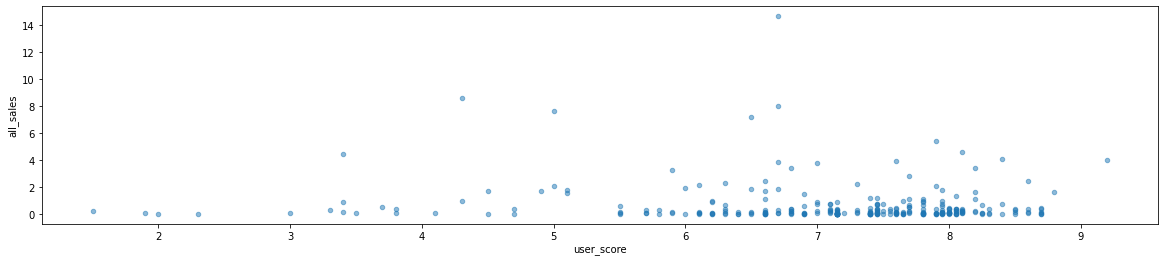

In [44]:
# корреляция продаж и отзывов пользователей
print('Коэффициент корреляции количества продаж игры от оценок пользователей:',
      round(data_top.loc[data_top['platform'] == 'PS4', :]['user_score'].corr(data_top.loc[data_top['platform'] == 'PS4', :]['all_sales']), 2))

data_top.loc[data_top['platform'] == 'PS4', :].plot(kind='scatter', x='user_score', y='all_sales', alpha=0.5, figsize=(20, 4));

Покупка игры на PS4 практически не зависит от отзывов критиков и пользователей. Иногда игру покупают даже вопреки плохим отзывам других пользователей.

Результат неожиданный, проверим имеется ли такая корреляция для других платформ.

Коэфф. корреляции количества продаж игры на "XOne" от оценок критиков/пользователей: 0.3 / -0.05


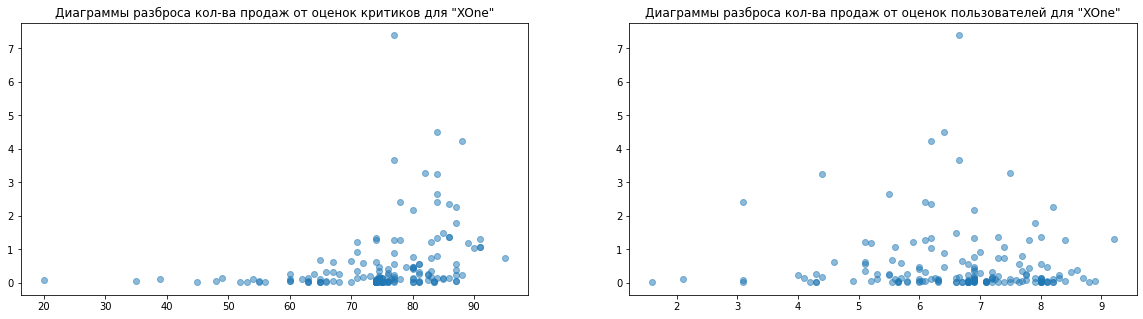

Коэфф. корреляции количества продаж игры на "3DS" от оценок критиков/пользователей: 0.04 / 0.08


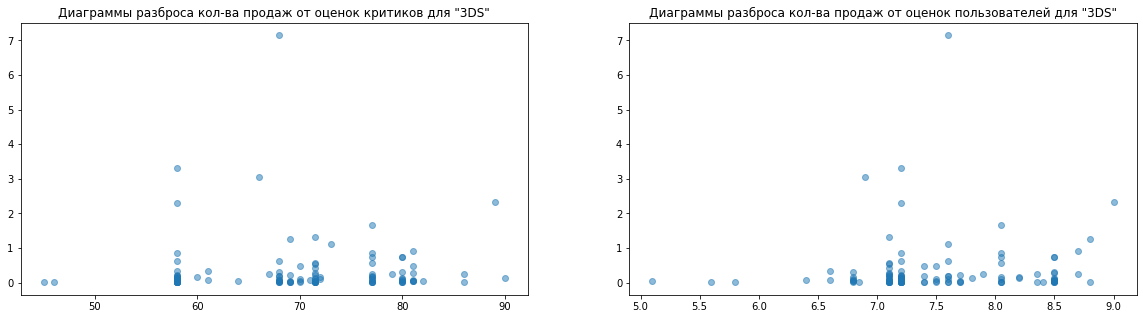

Коэфф. корреляции количества продаж игры на "PC" от оценок критиков/пользователей: 0.35 / 0.07


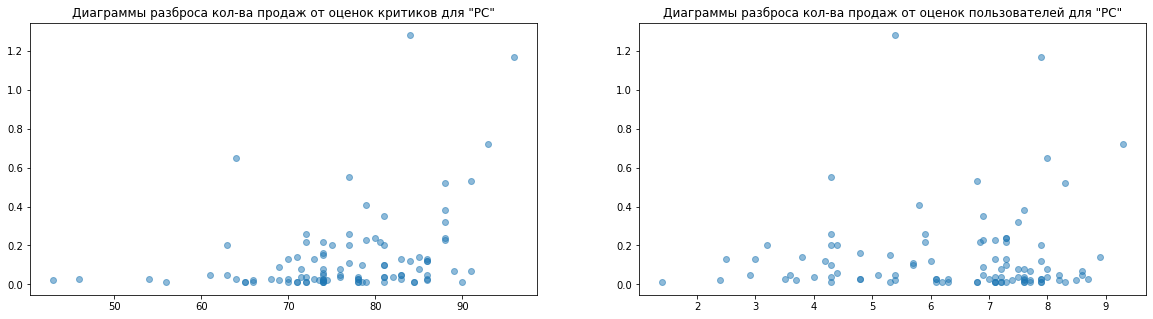

In [45]:
for platform in ['XOne', '3DS', 'PC']:
    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax_x1 = data_top.loc[data_top['platform'] == platform, 'critic_score']
    ax_x2 = data_top.loc[data_top['platform'] == platform, 'user_score']
    ax_y = data_top.loc[data_top['platform'] == platform, 'all_sales']
    
    #t1 = f'Диаграммы разброса кол-ва продаж от оценок критиков и пользователей для {platform}'
    ax1.scatter(ax_x1, ax_y, alpha=0.5)
    ax2.scatter(ax_x2, ax_y, alpha=0.5)
    
    ax1.set_title(f'Диаграммы разброса кол-ва продаж от оценок критиков для "{platform}"')
    ax2.set_title(f'Диаграммы разброса кол-ва продаж от оценок пользователей для "{platform}"')
    
    print(f'Коэфф. корреляции количества продаж игры на "{platform}" от оценок критиков/пользователей:',
          round(ax_x1.corr(ax_y), 2), '/', round(ax_x2.corr(ax_y), 2))
    
    plt.show()

Для остальных платформ какая-либо значимая зависимость между оценками и продажами так же не наблюдается.

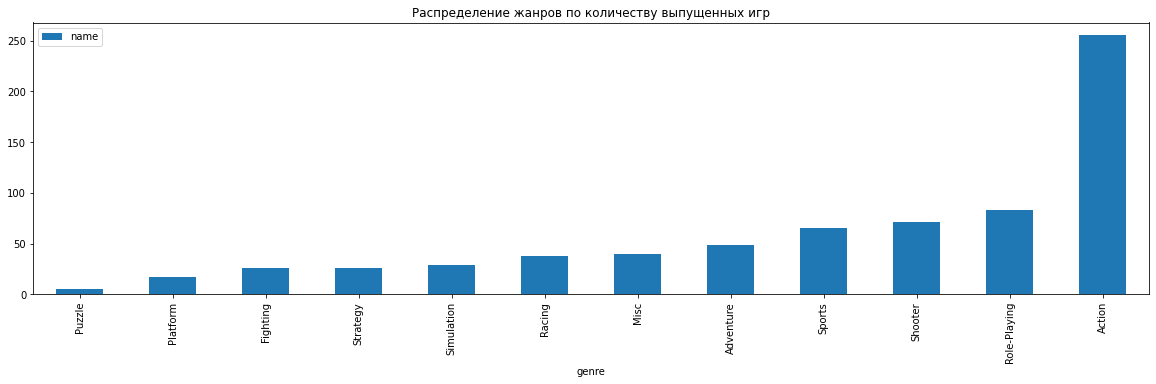

In [46]:
# исследуем зависимость продаж от жанра
data_top.pivot_table(index='genre',
                     values='name',
                     aggfunc='count').sort_values(by='name').plot(kind='bar', figsize=(20, 5),
                                                                    title='Распределение жанров по количеству выпущенных игр');

Игры, выпущенные для четырёх наиболее популярных платформ за 2015-2016 гг., чаще всего были в жанре "экшн", затем, с большим отрывом, следуют ролевые игры и прочие жанры. Наименее выпускаемыми были игры в жанре "головоломки".

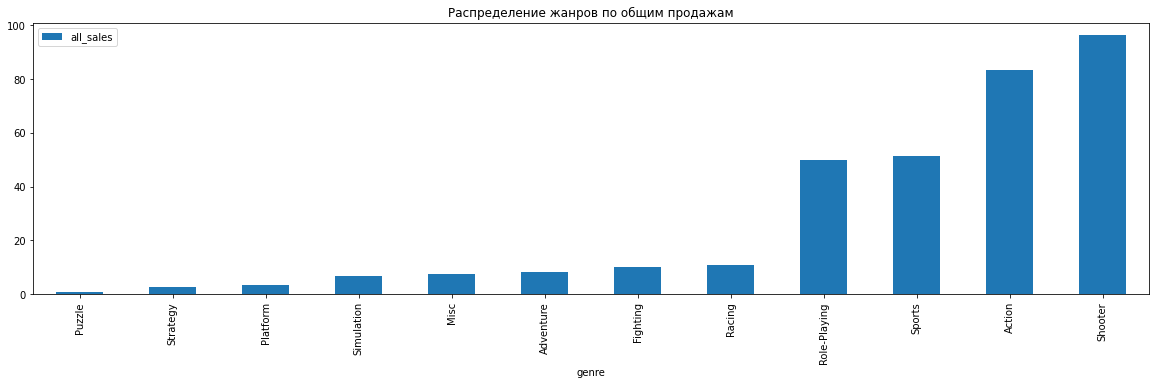

In [47]:
# распределение жанров по продажам
data_top.pivot_table(index='genre',
                     values='all_sales',
                     aggfunc='sum').sort_values(by='all_sales').plot(kind='bar', figsize=(20, 5),
                                                                    title='Распределение жанров по общим продажам');

Место по продажам и по количеству выпущенных игр соответсвует только для головоломок, они точно не популярны.

Продажи других жанров не соответсвуют количеству наименований. Это значит, что медианное количество проданных копий одной игры в определённом жанре может быть значительно больше чем в другом, т.е. один фактически популярнее другого.

Но так же возможно наличие отдельных бестселлеров, в которые играют все, в определённых жанрах.

В целом можно сказать, что игры в жанрах "экшн", "шутер", "ролевая" и "спортивные состязания" пользуются спросом и более разнообразны по наименованиям.

Сказать обратное можно о головоломках, стратегиях и файтингах.

### Определение портрета пользователя

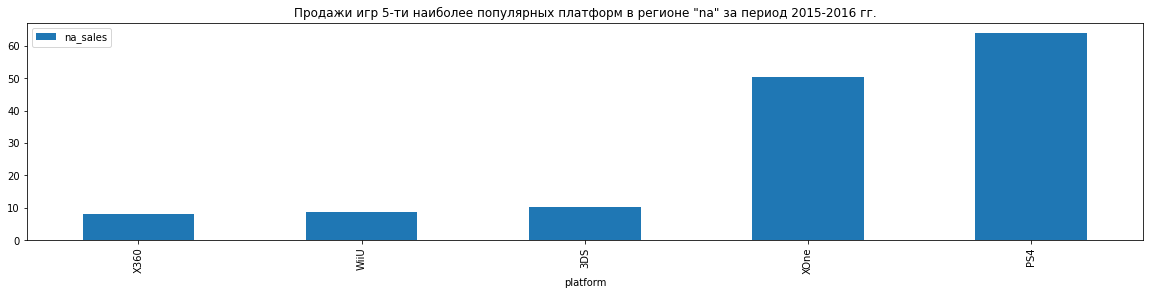

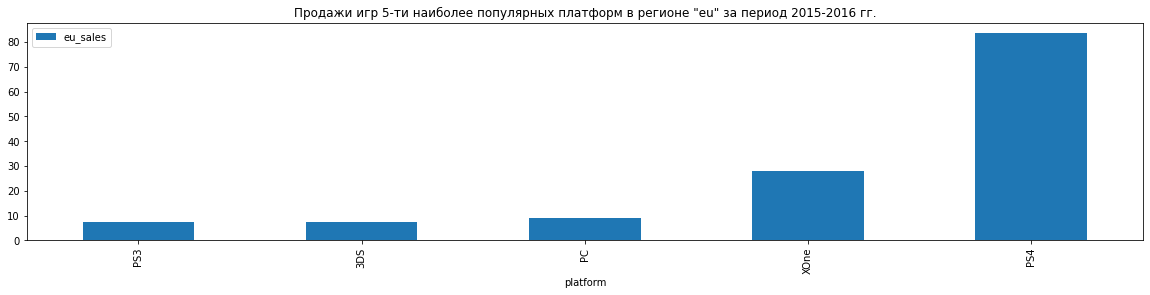

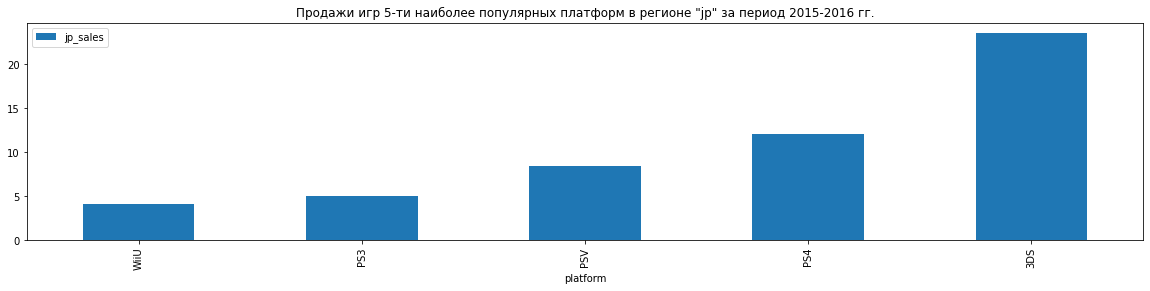

In [48]:
# определение наиболее популярных платформ по регионам
for region in ['na', 'eu', 'jp']:
    t = f'Продажи игр 5-ти наиболее популярных платформ в регионе "{region}" за период 2015-2016 гг.'
    reg_sales = f'{region}_sales'
    data_last.pivot_table(index='platform',
                          values=reg_sales,
                          aggfunc='sum').sort_values(by=reg_sales)[-5:].plot(kind='bar', figsize=(20, 4), title=t);

Для каждого из регионов популярность платформ отличается. Причём, если в Северной Америке и ЕС в топ-5 входят почти одни и те же платформы, но занимают различные позиции по продажам, то в Японии популярные платформы отличаются сильнее. Там платформа 3DS занимает первое место с большим отрывом, хотя в остальных регионах она лишь на 3-4 месте. Так же в Японии в на 3-м месте платформа PSV, которой нет в рейтинге в других рассматриваемых регионах.

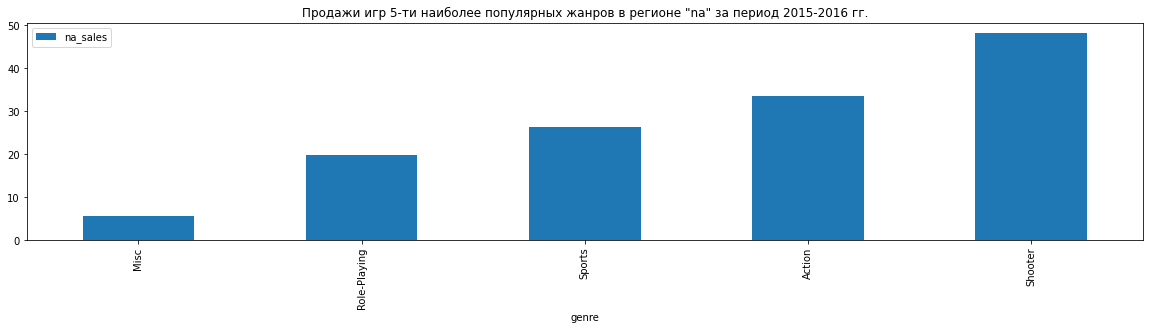

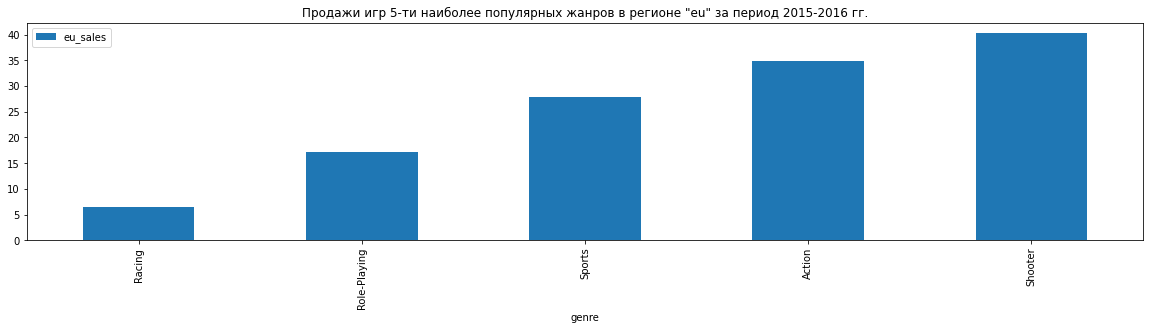

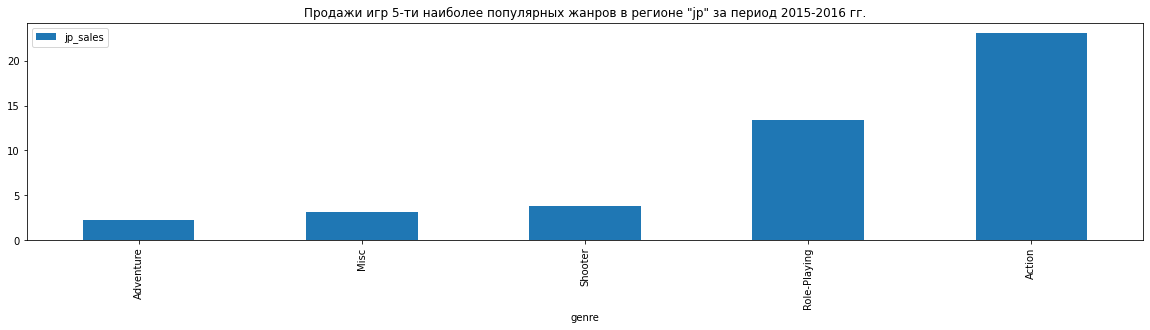

In [49]:
# определение наиболее популярных жанров по регионам
for region in ['na', 'eu', 'jp']:
    t = f'Продажи игр 5-ти наиболее популярных жанров в регионе "{region}" за период 2015-2016 гг.'
    reg_sales = f'{region}_sales'
    data_last.pivot_table(index='genre',
                          values=reg_sales,
                          aggfunc='sum').sort_values(by=reg_sales)[-5:].plot(kind='bar', figsize=(20, 4), title=t);

В Америке и Европе предпочтения пользователей похожи больше всего популярны экшены, шутеры и игры про спорт, ролевые игры только на 4-м месте. В Японии, хотя и популярнее всех, на втором месте ролевые игры, причем популярность оставшихся жанров заметно позади, и спортивных игр там нет.

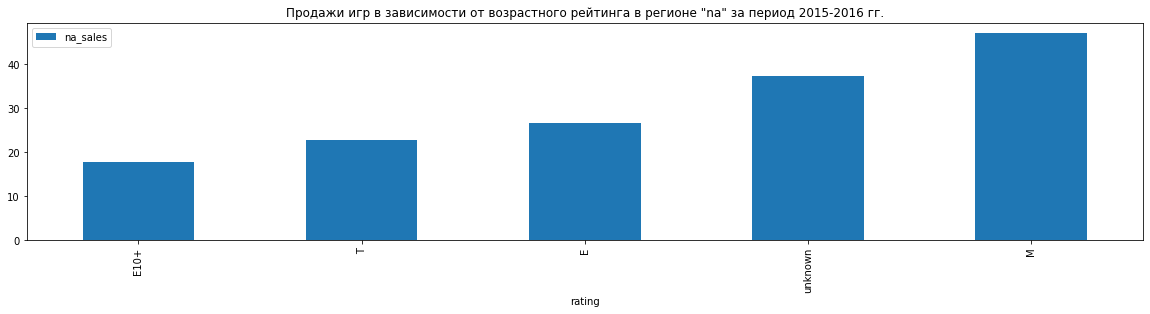

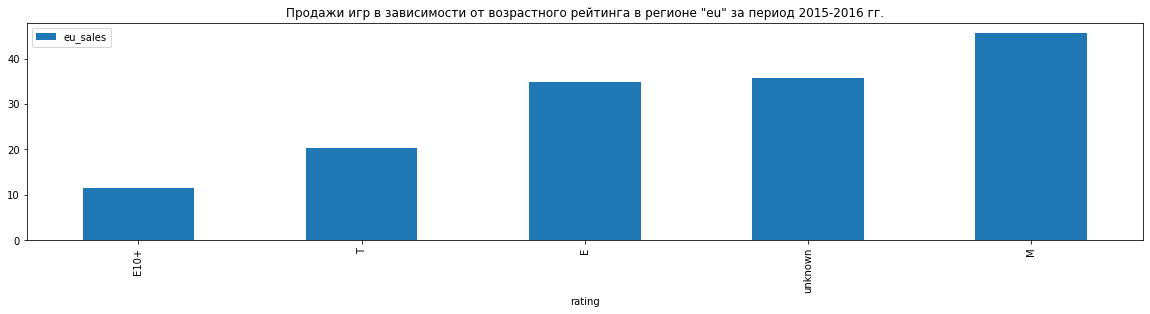

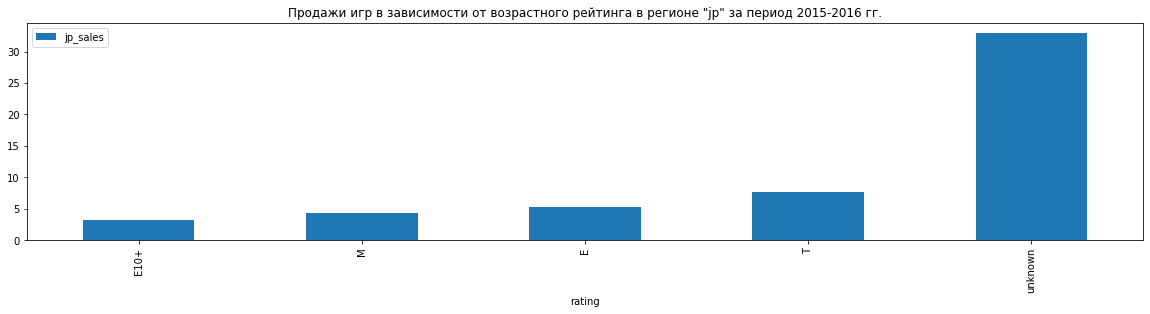

In [50]:
# популярность игр с определённым рейтингом по регионам
for region in ['na', 'eu', 'jp']:
    t = f'Продажи игр в зависимости от возрастного рейтинга в регионе "{region}" за период 2015-2016 гг.'
    reg_sales = f'{region}_sales'
    data_last.pivot_table(index='rating',
                          values=reg_sales,
                          aggfunc='sum').sort_values(by=reg_sales).plot(kind='bar', figsize=(20, 4), title=t);

Судя по графикам американцы и европецы предпочитают игры рейтинга М, включающие "достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику". Японцы же ограничиваются более спокойными играми, без излишне откровенных сцен.

В то же время в Японии игр без рейтинга намного больше. Это можно объяснить сильной национальной игровой индустрией (при этом многие игры выходят исключительно на японский рынок) и тем, что в Японии есть собственное рейтинговое агенство, и применять американский ESRB незачем.

### Проверка гипотез

**предположение №1: средние пользовательские рейтинги игр на платформах Xbox One и ПК одинаковы**

H0: средние пользовательские рейтинги игр на платформах Xbox One и ПК одинаковы

H1: средние пользовательские рейтинги игр на платформах Xbox One и ПК отличаются

In [51]:
# выборки значений пользовательских оценок для исследуемых платформ
u_score_xone = data_last.loc[data_last['platform'] == 'XOne', 'user_score'].dropna()
u_score_pc = data_last.loc[data_last['platform'] == 'PC', 'user_score'].dropna()

print('Размеры выборок:', u_score_xone.shape[0], u_score_pc.shape[0])
print('Средние значения выборок:', round(u_score_xone.mean(), 2), round(u_score_pc.mean(), 2))

Размеры выборок: 165 100
Средние значения выборок: 6.64 6.39


Несмотря на то, что размеры выборок достаточны и примерно равны. Платформы принципиально разные, но без дополнительных данных о пользователях сложно утверждать, что в их поведении есть принципиальные различия. Примем дисперсии равными.

In [52]:
# сравниваем две независимые совокупности, используем t-test
alpha = 0.05
results = st.ttest_ind(u_score_xone, u_score_pc, equal_var=True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.18790293830056715
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось. Вывод: значимого различия между средними пользовательскими оценками игр на платформах Xbox One и ПК не обнаружено (разница средних около 4%).

**предположение №2: средние пользовательские рейтинги игр жанров "экшн" и "спортивные соревнования" разные**

H0: средние пользовательские рейтинги игр жанров "экшн" и "спортивные соревнования" одинаковы

H1: средние пользовательские рейтинги игр жанров "экшн" и "спортивные соревнования" отличаются

In [53]:
# выборки значений пользовательских оценок для исследуемых жанров
u_score_action = data_last.loc[data_last['genre'] == 'Action', 'user_score'].dropna()
u_score_sports = data_last.loc[data_last['genre'] == 'Sports', 'user_score'].dropna()

print('Размеры выборок:', u_score_action.shape[0], u_score_sports.shape[0])
print('Средние значения выборок:', round(u_score_action.mean(), 2), round(u_score_sports.mean(), 2))

Размеры выборок: 425 104
Средние значения выборок: 6.98 5.23


Размеры выборок значительно отличаются, поэтому и их дисперсии так же могут отличаться.

In [54]:
# сравниваем две независимые совокупности, используем t-test
alpha = 0.05
results = st.ttest_ind(u_score_action, u_score_sports, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 6.591059706211676e-15
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Вывод: есть основания полагать, что средние пользовательские рейтинги игр жанров "экшн" и "спортивные соревнования" действительно отличаются (разница средних около 33%)

Оба предположения предполагают простое сравнения двух совокупностей, без дополнительных условий, и оба проверяются одинаковым способом.

За нулевую гипотезу принимается та, что утверждает **равенство** средних сначений двух генеральных совокупностей: всех существующих пользовательских оценок для Xbox One и ПК (или оценок для жанров "экшн" и "спортивные соревнования). В предположениях нет никаких дополнительных условий для сравнения, поэтому в качестве альтернативной гипотезы принимается простая противоположность нулевой.

Для проверки гипотез необходимо сравнить две независимые совокупности, поэтому применяем для этого Т-тест Стьюдента.

### Общий вывод

В рамках проекта был изучен датасет, исправлены ошибки в виде пропусков и дубликатов. Были исследованы все основные параметры. 
Изучена динамика продаж игр по годам. Выявлен средний срок сменяемости игровых платформ и найдены актуальные на текущий момент игровые платформы. Изучены особенности предпочтений пользователей из разных регионов и то, как они влияют на продажи. Сопоставлены некоторые параметры отдельных платформ.

На основе проведённых исследований сделан ряд нижеследующих выводов.

Последний консольных и ПК видеоигр пройден в 2008-2009 годах. На данный момент рынок консольных видеоигр находится в стадии падения, и, судя по тренду, продолжит падение и в 2017 году. Рынок игр на ПК стабилен, но значительно меньше по объёму. На текущий момент платформы PS4 и Xbox One и 3DS являются наиболе актуальными, но пик их популярности уже пройден, а с момента их выпуска прошло уже 6 лет и новых платформ, которые могли бы их сменить не появилось. В ближайшие годы должны появиться новые платформы, которые через 4-5 лет придут на смену текущим лидерам.

Несмотря на то, что со значительным отрывом, наиболее популярные консоли за 2015-2016 гг. являются консоли, стоит рассмотреть так же игры на ПК. За 2016 год так же стали продаваться немного лучше и вышли на 4е место по продажам, кроме того ПК как платформа достаточно стабильна и не "умрёт" в ближайшие годы. Игры продаются неодинаково хорошо - медианное значение продаж ниже среднего, значит при выбора торговой стратегии следует ориентироваться не только на платформу, но и на жанр или популярность отдельных игр.

Отзывы критиков и пользователей напротив практически не коррелируют с продажами, скорее являясь одним из способов поддержания активности сообщества и общего информирования об играх.

Наиболее популярным жанром по количеству выпущенных игр и по продажам, в целом по миру, является "шутер", наименее популярны игры-головоломки. В целом, количество наименований игр определённого жанра не говорит о его популярности у пользователей, т.к. для большинства жанров распределения по количеству игр и количеству продаж не соответсвуют.

В целом можно сказать, что игры в жанрах "экшн", "шутер", "ролевая" и "спортивные состязания" пользуются спросом и более разнообразны по наименованиям, чем другие игры в остальных жанрах.

Предпочтения пользователей заметно отличаются в зависимости от региона. В Северной Америке и Европе популярные платформы, жанры и возрастной рейтинг игр отличаются заметно отличаются от того же в Японии.

Сравнение отдельных категорий по средней пользовательской оценке подтвердили, что платформы Xbox One и ПК оцениваются пользователями примерно одинаково, а игры в жанре "экшн" и "спортивные состязания" по разному.